In [1]:
from __future__ import print_function
import os, time, random, glob
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
from torchvision import transforms
# from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

# 檢查系統與軟體版本
print(pd.__version__)
print(np.__version__)
print(torch.__version__)
!python -V
# !jupyter --version
!jupyter notebook --version
!jupyter lab --version

if not os.path.exists("meta/"):
    os.makedirs("meta/")

1.0.3
1.18.1
1.4.0
Python 3.6.10
6.0.0
1.2.1


### 1. 量化影像特徵  
#### 1.1. 用 encoder 將鱗翅目影像編碼  
- 編碼為 output shape==[N, 512] 的 array of features, N==照片總數。  
- 建議可從較小的數字開始練習，減少試誤時間。因為 GPU 正在訓練 DFC-VSC，萬一空間不夠，可能要用 CPU 練習。  
- 把完整的 features 存起來方便以後 reuse。數量與順序要與 metadata (科、屬、種、照片檔名) 一致。

#### 1.2. 畫出每一維特徵
- 用 decoder 生成每一維從 min to 0 to max 的連續值代表的影像。內插值間距自訂。
- 由於 VSC 抽出的特徵值會非常集中在 0 的附近，在極值附近(min to Q05 跟 Q95 to max) 可考慮用較細的間距。
- 最後要得到 512 組圖，每一組代表一個特徵從 min to 0 to max 的變化。

In [2]:
# 函式庫

str_to_list = lambda x: [int(xi) for xi in x.split(',')]

def is_image_file(filename):
    return any(filename.lower().endswith(extension) for extension in [".jpg", ".png", ".jpeg",".bmp"])

def load_model(model, pretrained, map_location=None):
    weights = torch.load(pretrained, map_location=map_location)
    pretrained_dict = weights['model'].state_dict()  
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict) 
    model.load_state_dict(model_dict)
    
def im_convert(tensor, f_name=None, save=False):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)              # (c,w,h) > (w,h,c)
#     image = image*std + mean                      # unnormalize
    image = image.clip(0, 1)
    plt.figure(figsize=(16, 12))
    plt.title(f'{f_name}')
    plt.imshow(image)
    
    if save:
        fig_Name =  f"./results/latent/{f_name}.png"
        plt.savefig(fig_Name,
                    bbox_inches='tight',
                   )
        print(f'{fig_Name} Saved')


### 定義model

#### load model 

In [3]:
# from MothScripts.dataset import ImageDatasetFromFile
# from MothScripts.networks import DFC_VSC_WGAN
# from MothScripts.resnet50_classifier import ResNet50_family_classifier
# from MothScripts.average_meter import AverageMeter

# 指定GPU位置
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# torch.cuda.empty_cache()  # 清除GPU記憶體暫存


# channels= [32, 64, 128, 256, 512, 512]
# model = DFC_VSC_WGAN(channels=channels, discrimination=False)

ck = 5000
# map_location = 'cuda:1'  # 'cuda:1'  or 'cpu'
# ck_path = f'model/vsc_wgan/backup/model_local_epoch_{ck}_iter_0.pth' 
# load_model(model, pretrained=ck_path, map_location=map_location)
# model = model.to(device)

#### load data

In [4]:
# #-----------------load dataset--------------------------
# dataroot = "/home/jovyan/Autoencoder/wolrdwide_lepidoptera_yolov4_cropped_and_padded_20210610"
# batch_size = 16  # 為避免gpu爆掉，最大約16

# image_list = [x for x in glob.iglob(dataroot + '/**/*', recursive=True) if is_image_file(x)]
# train_list = image_list[:]
# assert len(train_list) > 0

# train_set = ImageDatasetFromFile(train_list, aug=False)

# train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=False)
# num_of_batches = len(train_data_loader)

In [5]:
# # 精簡的寫法。等價於下面cell的寫法。但此寫法容易塞爆記憶體
# with torch.no_grad():
#     features = torch.cat([model(images.to(device)) for images, *_ in train_data_loader])
# print(features.shape)
# np.save(f'./meta/features_ck{ck}.npy', features.cpu().numpy())

In [6]:
# # 較複雜的寫法
# start_time = time.time()
# for i, (images, *_) in enumerate(train_data_loader):
#     images= images.to(device)
#     with torch.no_grad():
#         mu, logvar, logspike, z, x_rec = model(images)
#     if i == 0 :
#         features = z
#     else:
#         features = torch.cat((features, z), dim=0)      
#     t_pass = time.time()-start_time
#     print(f'progress:{i+1:4d}, {100*(i+1)/len(train_data_loader):3.2f}%. Time: {t_pass//(60*60) :.0f}h, {t_pass/60%60 :.0f}m, {t_pass%60 :.0f}s, feature_shape: {features.shape}', end='\r')

# np.save(f'./meta/features_ck{ck}.npy', features.cpu().numpy())

In [7]:
# # 抓取檔案metadata
# meta = pd.read_csv(f'./meta/moth_meta.csv')

# ## 存取features(ndarray)
# dimensions = pd.DataFrame(np.load(f'./meta/features_ck{ck}.npy'))
# ## 將meta與features array合併儲存
# features_meta = pd.merge(moth_meta, dimensions, left_index=True, right_index=True)
# features_meta.to_csv(f'./meta/features_ck{ck}_meta.csv', index=False)

In [8]:
features = np.load(f'./meta/features_ck{ck}.npy')
features.shape

(32262, 512)

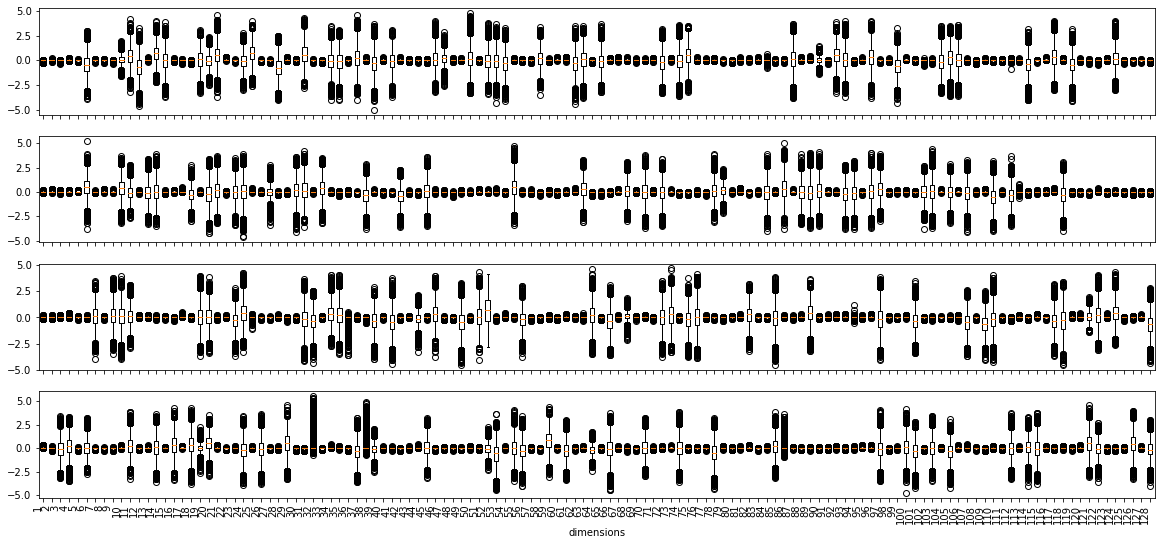

In [12]:
# 繪製512維的特徵分布圖
fig, axs = plt.subplots(4,1,figsize=(20,10))

for i in range(4):
    axs[i].boxplot(features[:,i*128:(i+1)*128])
#     axs[i].set_xlabel( [t for t in range(i*128,(i+1)*128)])
plt.xlabel('dimensions')

fig.autofmt_xdate(rotation=90)
fig.savefig(f"./results/latent/features_boxplot_ck{ck}.png", bbox_inches='tight')

In [ ]:
for i in range(4):
    axs[i].boxplot(features[:,i*128:(i+1)*128])
#     axs[i].set_xticks([i for i in range(i*128,(i+1)*128)])
plt.xlabel('dimensions')
# plt.title('B')
fig.autofmt_xdate(rotation=90)

In [ ]:
# 檢視512維特徵值的分布
# for v in range(512):
#     f = features[:,v]
#     print(f'v:{v:3d},  min:{f.min():.3f},  max:{f.max():.3f}, mean:{f.mean():.3f}, std:{f.std():.3f}')

#### 將latent space 內的512個特徵值內插作圖

In [ ]:
# n=16
# model.to('cpu')
# for f in range(512):
#     zero = torch.zeros((1,512))
#     # 產出該維度特徵內插值
#     fea = features[:,f]
#     dis = 1.1*(fea.max()-fea.min())/2  # 計算該維度的值分布範圍
#     linspace = torch.tensor(np.concatenate((np.linspace(-dis, 0, n), np.linspace(0, dis, n))))
# #     linspace = torch.tensor(np.linspace(-5,5, n))
#     dimension_list = []
#     for l in linspace:
#         zero[0][f] = l
#         dimension_list.append(zero.clone())
        
#     # 將該維度內插值送入decoder產生ㄟ圖像
#     x_hat_list = []
#     for d in range(len(dimension_list)):
#         with torch.no_grad():
#             x_hat = model.decoder(dimension_list[d]) 
#             x_hat_list.extend(x_hat)
#     im_convert(torchvision.utils.make_grid(x_hat_list, nrow=8, padding=2), f_name=f'Dimensions_{f}' , save=True)
#     if f==0:break

In [ ]:
# fig, ax_array = plt.subplots(16, 32, figsize=(30,15))
# axes = ax_array.flatten()
# for i, ax in enumerate(axes):
#     ax.hist(features[:,i], bins=10)
# plt.savefig(f"./results/latent/Features_hist.png", bbox_inches='tight')

#### 繪圖檢視各科物種特徵的平均值

In [5]:
moth_meta = pd.read_csv(f'./meta/moth_meta_20210610.csv')
moth_meta 

,Family,Subfamily,Genus,Species,SciName,Number,Source,Family_encode,Fam_Sample,Fam_Specie
0,Notodontidae,Phalerinae,Datana,perspicua,Datana perspicua,2432375495,CSU,60,741,530
1,Geometridae,Ennominae,Borbacha,pardaria,Borbacha pardaria,A37-20180907-057,TESRI,34,4684,3138
2,Geometridae,Ennominae,Cleora,fraterna,Cleora fraterna,A34-20130506-024,TESRI,34,4684,3138
3,Tortricidae,Olethreutinae,Olethreutes,osmundana,Olethreutes osmundana,1838875462,MISSA,84,938,802
4,Geometridae,Geometrinae,Hemistola,monotona,Hemistola monotona,A52-20160704-154,TESRI,34,4684,3138
...,...,...,...,...,...,...,...,...,...,...
32257,Tineidae,Tineinae,Tinea,occidentella,Tinea occidentella,2432338673,CSU,82,102,85
32258,Geometridae,Geometrinae,Episothalma,robustaria,Episothalma robustaria,1826442741,NHMUK,34,4684,3138
32259,Oecophoridae,Depressariinae,Eupragia,hospita,Eupragia hospita,1585226502,MISSA,62,70,65
32260,Nymphalidae,Limenitidinae,Neptis,hylas,Neptis hylas,1039028551,YPM,61,3999,1655


In [7]:
# 建立科名encoing的字典對照表  
Fam_dic = dict(zip(range(97),
                   moth_meta.Family.sort_values().unique()))        # 取得科名按字母排序

In [60]:
for i,(_,v) in enumerate(Fam_dic.items()):  # k:Family_encode, v:Family
    # 取得各科特徵值的平均
    mask = moth_meta.Family.isin([v])  # 等同於 f_meta.Family==k
    index = moth_meta[mask].index
    f_mean = torch.tensor(features[index,:].mean(axis=0)).reshape((-1,512))  # (512,) >　torch.Size([(1, 512)])
    if i==0:
        features_mean = f_mean
    else:
        features_mean = torch.cat((features_mean, f_mean), dim=0)
print(f'feature_shape: {features_mean.shape}')  # torch.Size([(97, 512)])

# 將取均值的特徵送入decoer產生重建的影像
with torch.no_grad():
    rec = model.decoder(features_mean)  # torch.Size([97, 3, 256, 256])

In [ ]:
# 繪圖-將97科蛾類繪製在一張圖上
fig, axes = plt.subplots(7,14, figsize=(32,18))
for i, ax in enumerate(axes.flat):
    ax.set_yticks([]); ax.set_xticks([]); ax.axis('off') # 隱藏邊框及刻度 
    if i < len(rec) :                                    # 蛾類有97科
        image = (rec[i].numpy()
                 .transpose(1, 2, 0) # (c,w,h) > (w,h,c)
                 .clip(0, 1))         
        ax.imshow(image)
        get_Family = f_meta[f_meta.Family_encode == i]   # 取得科名
        sp =  get_Family.Fam_Specie.unique()[0]          # 各科物種數
        n =   get_Family.Fam_Sample.unique()[0]          # 各科樣本數
        ax.set_title(f'{Fam_dic[i]}\n sp:{sp}, n:{n}',
                     {'fontsize': 12} )
plt.savefig(f'./results/family_Feature_Mean/Mean_All_Nbelow10.png', bbox_inches='tight');

In [ ]:
# 繪圖-將97科蛾類各自繪圖
for i,(_,v) in enumerate(Fam_dic.items()):  
    image = (rec[i].numpy()
             .transpose(1, 2, 0) # (c,w,h) > (w,h,c)
             .clip(0, 1))    
    plt.title(f'{v}_Mean', {'fontsize': 16} )
    plt.imshow(image)
    plt.savefig(f'./results/family_Feature_Mean/Mean_{v}.png', bbox_inches='tight')
    print(f'Mean_{v}.png saved! \t\t', end='\r');

### 2. 降維探索
#### 2.1. 將編碼後的 features 用 UMAP 降維
- UMAP 工具參見 https://pypi.org/project/umap-learn/
- 如果跑不動 3 萬餘張照片，可先對每個種求平均後再降到 2 or 3 維。  
  @YYChen 用的 AS-GPU 上之前應該有裝好了。  
  @YungHuiHsu 如果裝不起來(會有一大堆軟體版本衝突)，超過一小時依然無法解決，請找 @GSMai 。

#### 2.2. 畫降維後的 scatter plot
- 依科上色，現階段應該已經可以看出特徵有照科群聚的特性了。
  - 如果因為科數量太多而看不清楚，可先挑選前 20 或前 50 大科試試。
  - 科的大小以科內物種數決定。

#### 2.3. 找出最佳的 n_neighbors 參數 
- UMAP n_neighbors 的 default==15
- 可嘗試如 50, 100 or 200，並以分群評估指標如 Silhouettes, Calinski Harabaszs, Davies Bouldins 來尋找最適 hyper-parameters。  
  - 前兩者愈大愈好，後者愈小愈好，細節請先參照 sklearn 官方文件。

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
# %matplotlib widget
sns.set(style='white', context='notebook', rc={'figure.figsize':(16,12)})

In [2]:
from umap import UMAP

In [3]:
ck = 5000
features = np.load(f'./meta/features_ck{ck}.npy')
features.shape

(32262, 512)

### 選取前20、50大科作圖
- 依樣本數量
- 依物種數量

1. 計算各科樣本、物種數量，新增欄位保留計算結果
2. 抓取想要的科所對應的INDEX位置
3. 匯圖時直接抓取對應的INDEX

In [14]:
# 檢視各科案樣本數量取樣的分布狀態
fam_Sample = moth_meta.Fam_Sample.unique()
number_list=[10,50,100,500,1000] 

print('Samples per Family :', end='\t')
for n in number_list:
    print(f'{n:2d}:{np.sum(fam_Sample > n):2d}.', end=' '*4)
# pd.DataFrame(fam_Sample).plot(kind='hist',bins=100, figsize=(6,3), title='Samples per Family' );

# 檢視各科按物種數量取樣的分布狀態

fam_Specie = moth_meta.Fam_Specie.unique()
print('\nSpecies per Family :', end='\t')
for n in number_list:
    print(f'{n:2d}:{np.sum(fam_Specie > n):2d}.', end=' '*4)
# pd.DataFrame(fam_Specie).plot(kind='hist',bins=100, figsize=(6,3), title='Species per Family' );

Samples per Family :	10:41.    50:25.    100:21.    500:14.    1000: 9.    
Species per Family :	10:41.    50:25.    100:18.    500:10.    1000: 4.    

##### 計算各科物種數、樣本數

### 分群評估指標  
- Silhouettes(輪廓係數)
  - 介於-1 ~ 1，越接近-1表示樣本越應該被分類至其他群集。越大越好
  - $ \frac{b-a}{max(a,b)}$
    - a: 該點與同群集內，其他樣本的平均距離
    - b: 該點與最近相鄰群集內，其他樣本的平均距離 
- Calinski Harabaszs(Variance Ratio Criterion)
  - 所有群集的 群間分散度/群內分散度 加總(分散度定義採用距離均方)
  - 越大代表群間越分離、群內越聚集
- Davies Bouldins
  - 聚類之間的平均 "相似度": 將群之間的距離與群本身的大小進行比較
  - 越接近0代表樣本分配越好
  - $\frac{s_i + s_j}{d_ij}$   
    - s: 群內每個點與該群中心點的平均距離(群的直徑)
    - d: 群中心點i和j之間的距離。


In [10]:
n_neighbors = [50, 100, 200, 300, 400, 500, 750, 1000]

In [2]:
def get_embedding(n_components=3, n_neighbors=n_neighbors, metric='euclidean'):
    for n in n_neighbors:
        reducer = UMAP(n_components=n_components, n_neighbors=n, verbose=True, metric=metric)
        embedding = reducer.fit_transform(features)
        root = f'meta/embedding/embedding_{n_components}D_Nneighbors{n}.npy'
        np.save(root, embedding)
        print(f'{root} saved', end='\r') 
    print(f'Finished') 

In [6]:
n_components = 3
def clustering_metric_score(metric="silhouette" , n_range=None):
    '''
        metric = "silhouette" or "calinski_harabasz" or "davies_bouldin"
    '''
    scores = []
    for n in n_range:
        features_ = np.load(f'meta/embedding/embedding_{n_components}D_Nneighbors{n}.npy')
        
        if metric == "silhouette":
            score = metrics.silhouette_score(features_, moth_meta.Family)
        if metric == "calinski_harabasz" :
            score = metrics.calinski_harabasz_score(features_, moth_meta.Family) 
        if metric == "davies_bouldin" :
            score = metrics.davies_bouldin_score(features_, moth_meta.Family) 
        
        scores.append(score)
        print(f'N: {n:2d}, {metric} Score: {score:.3f} ', end='\r')
    return scores

In [13]:
n_range = n_neighbors
sil_scores, ch_scores, db_scores = [], [], []

for metric in ["silhouette", "calinski_harabasz", "davies_bouldin"]:
    score = clustering_metric_score(metric=metric , n_range=n_range)
    if metric == "silhouette":
        sil_scores += score
    if metric == "calinski_harabasz":
        ch_scores += score 
    if metric == "davies_bouldin":
        db_scores += score

In [26]:
# data = [sil_scores, ch_scores, db_scores]
# metric_score = pd.DataFrame(
#     np.array(data).T,
#     index=n_range,
#     columns=["silhouette" , "calinski_harabasz", "davies_bouldin"]
#             )

# metric_score.to_csv(f'meta/clustering_metric_score_NneighborsTest.csv')
metric_score = pd.read_csv(f'meta/clustering_metric_score_NneighborsTest.csv',header=[0], index_col=0)
metric_score


,silhouette,calinski_harabasz,davies_bouldin
50,-0.192720,2260.817741,8.559465
100,-0.202678,2350.622164,7.121263
200,-0.181120,2465.289463,8.310466
300,-0.173453,2920.090610,6.508552
400,-0.174386,2887.169116,6.098070
500,-0.164389,2790.591320,6.234795
750,-0.177738,2824.598023,6.300707
1000,-0.171880,2867.216909,6.199777


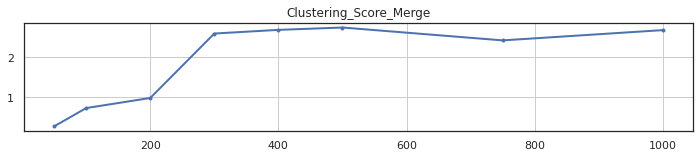

In [19]:
figsize=(12, 2); marker="."; lw = 2
metric_score_merge.plot(title="Clustering_Score_Merge" , grid=True, figsize=figsize, lw=lw, marker=marker);         # 三個指標標準化後加總

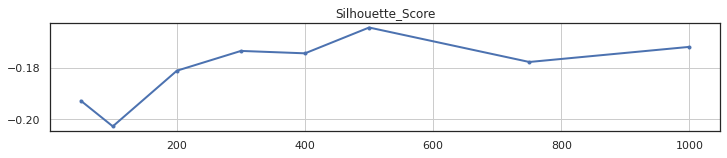

In [23]:
metric_score.silhouette.plot(title="Silhouette_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

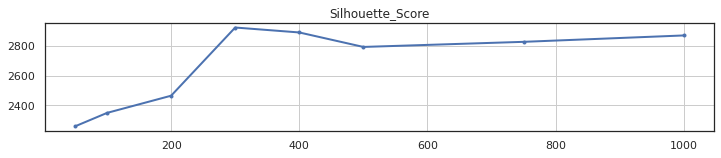

In [24]:
metric_score.calinski_harabasz.plot(title="Silhouette_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

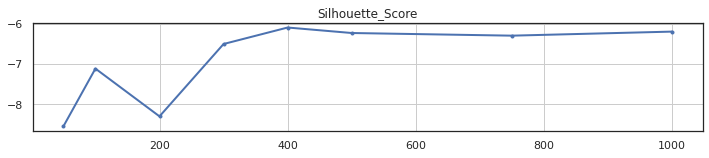

In [25]:
metric_score.davies_bouldin.plot(title="Silhouette_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

In [27]:
#　將三個metric標準化處理，取值在0~1。
metric_score.davies_bouldin = metric_score.davies_bouldin*-1  # davies_bouldin為越小越佳，因此先乘上負號
metric_score_ = (metric_score -  metric_score.min()) / (metric_score.max() -  metric_score.min())
# idx = pd.IndexSlice
# metric_score_.loc[:, idx[:, "2D"]].sum(axis=1)
# metric_score_.loc[:, idx[:, "3D"]].sum(axis=1)
metric_score_merge = metric_score_.sum(axis=1)

print("Best N_neighbors: \n", metric_score_merge.idxmax())  # 檢視分群最佳結果的 N_union
print()
print("Score : \n", metric_score_merge.max())

Best N_neighbors: 
 500

Score : 
 2.7480251064437007


### 分群指標評估- n_neighbors：
- 分群指標最佳位置落在N_neighbors = 500
- 不過 300 - 1000 得分其實差不多

#### ~分群指標評估- n_neighbors：~
- n_neighbors在小於50內較不穩定
- metric採用 cosine與euclidean 沒有明顯一致的差異
  - VSC處理得到的latent space 會以0為中心($u=0$)，呈slab+spike分布 
- 各指標
  - Silhouettes在200-500間到曲線高原位置
  - Calinski Harabaszs在200-500間到曲線高原位置(越大越好，分子為群間距離變異、分母為群內距離)
  - Davies Bouldins低點在100-500間
  - 三種指標綜合考量，選取200或300較合適

### 2D作圖

### 單色作圖
1. 疊兩個圖層
  1. 指定欲上色的科別(編碼)-圖層1
  2. 其他則用灰階-圖層2
2. 選出指定的科名(編碼)
  - 將其他沒有選擇的編碼指定為-99，並將顏色指定為灰色

In [17]:
def cluster_2DplotByS(n_neighbors=200, metric='euclidean', sample=500, save=None):    
    
    # 取得基本資料
    index = moth_meta[f_meta.Fam_Sample > sample].index                    # 指定取樣的科數。 依據樣本Fam_Sample 或依據物種數Fam_Specie
    embedding_ = pd.DataFrame(np.load(f'./meta/embedding_2D_{metric}_{n_neighbors}.npy'))
    meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
    embedding = pd.concat( [embedding_ , meta_], axis=1)
    sample_list = embedding.iloc[index,:].Family.sort_values().unique() # 從已篩選過樣本數量的embedding中建立類別(科)清單
    print('Samole Number:', len(sample_list), sample_list)
    
    for i, f in enumerate(sample_list):
        print(f'Ploting {f} ...')
        plt.close()                                                     # 清空前一張圖避免重疊繪圖，以及釋放記憶體空間
        fig = plt.figure(figsize=(16,9),clear=True)
        ax = plt.subplot()
        indexByS = moth_meta[f_meta.Family == f].index                     # 取得單一物種的index位置 
        
        ax.scatter(embedding.iloc[index, 0], embedding.iloc[index, 1],  # 建立所有類別的scatter底圖
                    c='lightgrey', lw=.1, s=3)

        # 建立單一欲顯色的類別scatter圖
        scatter = ax.scatter(embedding.iloc[indexByS, 0], embedding.iloc[indexByS, 1],
                             c=embedding.iloc[indexByS, 3],
                             lw=.1, s=9, edgecolors='b', cmap='Spectral')
        
        # 取出legen元素，圖標 handles與 標籤labels
        handles, labels = scatter.legend_elements()  # labels
        family_list = [Fam_dic[int(labels[l].split("{")[1].split("}")[0])] for l in range(len(labels))]  # 將編碼過的數字標籤反轉換為文字
        ax.legend(
        #     *scatter.legend_elements(),
            handles=handles, labels=family_list,
            title='Family', ncol=4, markerscale=1)

        plt.title(f'UMAP_Moth - {f}', fontsize=24)
        plt.suptitle(f'n_neighbors:{n_neighbors},\n sample>{sample} ', x=0.75, y=0.92, fontsize=12, fontweight='light')
        plt.gca().set_aspect('equal', 'datalim');
        if save==True:
            plt.savefig(f"./results/umap/Umap_2D_sample{sample}_neighbor{n_neighbors}_{f}.png", bbox_inches='tight')
        

In [ ]:
cluster_2DplotByS(sample=100, save=True)

### 3D作圖

In [20]:
# 設定版型
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(12,10)})

family_N_Specie = moth_meta.groupby("Family").SciName.nunique().sort_values()[::-1]   # 建立科名與物種數量的索引
# index_n_unions = np.load(f'{path_root}/meta/index_n_unions.npy', allow_pickle=True)
# df_Nuniun = pd.DataFrame([len(n) for n in index_n_unions], index=range(1,51), columns=["N_uniun"] )

def cluster_ploting(reducer="PCA", n=None, dim=2, sample=100, save=None):

#     n_union = df_Nuniun.loc[n].item()                         
    index = moth_meta[moth_meta.Fam_Specie > sample].index  # 指定取樣的科數。 依據樣本Fam_Sample 或依據物種數Fam_Specie
    familys = family_N_Specie[family_N_Specie>sample].index    # 指定取樣的科。 依據各科物種數Fam_Specie
    
    embedding = pd.DataFrame(
        np.load(f'meta/embedding/embedding_{dim}D_Nneighbors{n}.npy')
    )
    
    fig = plt.figure()
    cmap='Spectral'; lw=.1; s=9; edgecolors='black'; alpha=0.5  # parameters of ax.scatter
    
    if dim==2: 
        ax = plt.axes()
        x=0.75; y=0.91 # suptitle loc
        for family in familys:
            index = moth_meta[moth_meta.Family == family ].index
            scatter = ax.scatter(embedding.iloc[index, 0], embedding.iloc[index, 1],
                        cmap=cmap, lw=lw, s=s, edgecolors=edgecolors, alpha=alpha)
        fig.gca().set_aspect('equal', 'datalim')
        
    if dim==3:
        ax = Axes3D(fig)
        x=0.75; y=1.03 # suptitle loc
        for family in familys:
            index = moth_meta[moth_meta.Family == family ].index
            scatter = ax.scatter(embedding.iloc[index, 0], embedding.iloc[index, 1], embedding.iloc[index, 2],
                                     cmap=cmap, lw=lw, s=s, edgecolors=edgecolors, alpha=alpha)
        # 控制邊界
        axisEqual3D(ax)
#         xlim=6; ylim=6; zlim=6
#         ax.set_xlim(-xlim, xlim); ax.set_ylim(-ylim, ylim); ax.set_zlim(-zlim, zlim)
        
    # 取出legen元素，圖標 handles與 標籤labels
    ax.legend(labels=familys, title='Family', ncol=5, markerscale=3, frameon=True)
    
    plt.title(f'Clustering of\nMoth Features', fontsize=20, loc='center')
    plt.suptitle(f'{reducer}\n, Nneighbors : {n}, species > {sample}', fontsize=10, fontweight='light', x=x, y=y)
    
    if save==True:
        plt.savefig(f"./results/{reducer}/{reducer}_{dim}D_Nneighbors{n}_sample{sample}.png", bbox_inches='tight');

def axisEqual3D(ax=None):
    '''control axis limit for cluster_ploting'''
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = 0.65 * maxsize / 2               # setting scale
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

In [ ]:
# for n in n_neighbors:
#     cluster_ploting(reducer="UMAP", n=n, dim=3, sample=500, save=True)
# #     plt.close()
    

### Note
- 列出 n_neighbors = [50, 100, 200, 300, 400, 500, 750, 1000]時，3D繪圖分群的結果
- 大致均分為兩大群(蝶與蛾)，弄蝶介於中間
- n_neighbors 300起，蛾的分群有拉得比較開  
- 如同分群指標所示，300 -1000結果差異不大
- n_neighbors >1000後無法計算

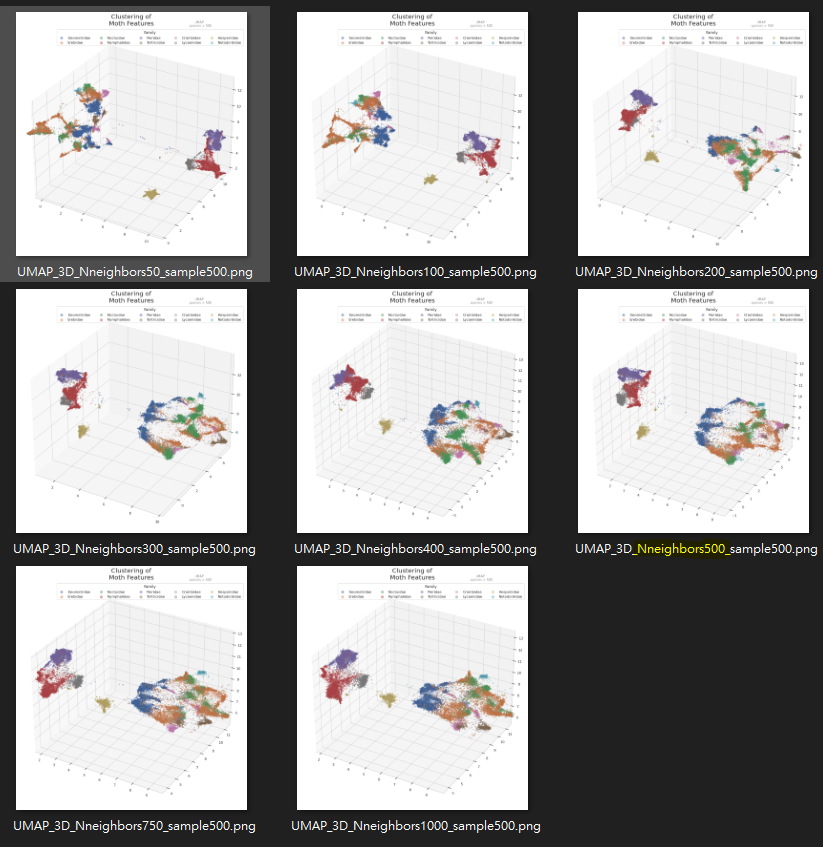